# This web scrapping project is designed to help people in job search. The data was scraped from Indeed. I defined a list of the skills set, that I thought would be important to have as a Data Analyst or Data Scientist. Then I scraped a total of 300 jobs and matched the skills required in jobs to the list that I had with predefined skills. Graphs and charts were designed using Matplotlib.

In [19]:
import csv
import re
import numpy as np
import pandas as pd
import urllib
from indeed import IndeedClient
from bs4 import BeautifulSoup as BS

In [20]:
totalRecords = 100
topPercentageSkills = .20
threshold=topPercentageSkills*totalRecords

In [21]:
def extractSkills2(jobLink,skillList):#this function is for matching our skills to the skills in the string
    skillDict={}
    String=extractInfoFromLink(jobLink).lower().replace(',', '').replace('.', '')
    for skill in skillList:
        if(String.find(skill.lower(), 0) > 0):
            skillDict[skill]=1
        else:
            skillDict[skill]=0
    return skillDict

def extractInfoFromLink(jobLink):# this function is for extracting skills paragraph from the string(string we are getting from the url.)
    url=urllib.urlopen(jobLink)
    soup=BS(url,'html.parser')
    Text=soup.findAll('div',attrs={'class':"jobsearch-JobComponent-description"})
    return cleanhtml(str(Text))


def cleanhtml(Data):# this function will remove the HTML tags from the string
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', Data)
    return cleantext  

def readSkillsList(filename):
    skillsList=[]
    with open(filename, 'rb') as csvfile:
        skills = csv.reader(csvfile, delimiter=' ')
        for skill in skills:
            skillsList.append(' '.join(skill) + ' ')
    return skillsList

def getIndividualDF(client, user, job, location, count, skillfile):#Getting Json object from Indeed
    startList=np.arange(1,count*5,25) #taking total of 200 jobs. Since the limit is 25 at a time,using forloop.
    skillsList = readSkillsList(skillfile)
    counter =0
    SkillDf=pd.DataFrame()
    for num in startList:
        if counter >= count:
            break
        
        params = {
            'q' :job,#for the whole group we can use for loop for different jobtitles.
            'l' : location,
            'limit':25,     #25 records is the maximum we can get 
            'start':num,
            'radius':75,
            'userip' : "1.2.3.4",
            'useragent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2)"
        }
        search_response = client.search(**params)
        #print search_response
        for i in range(25):
            title=search_response["results"][i]['jobtitle']
            
            if job.lower() not in title.lower():#specifically for dataanalyst jobs..
                continue

            directSeriesfromJSON=pd.Series(search_response["results"][i],index=['jobtitle', 'company', 'city'])
            url=search_response["results"][i]['url']
            directSeriesfromJSONurl=pd.Series(search_response["results"][i],index=['url'])
            directSeriesfromJSONdate=pd.Series(search_response["results"][i],index=['date'])
            directSeriesfromJSON = directSeriesfromJSON.append(directSeriesfromJSONurl).append(directSeriesfromJSONdate)
            MatchSkill=extractSkills2(url,skillsList)
            seriesWithMatchSkill=pd.Series(MatchSkill,index=skillsList)
            combinedSeries=directSeriesfromJSON.append(seriesWithMatchSkill)
            #print combinedSeries
            SkillDf=SkillDf.append(combinedSeries,ignore_index=True)
            counter = counter +1
            if counter >= count:
                break

    #beacuse city,company and title was coming to the last in the dataframe & we need to represent them first.we modified tthe skillslist.       
    skillsList.insert(0, 'city')
    skillsList.insert(0, 'company')
    skillsList.insert(0, 'jobtitle')
    skillsList.insert(0, 'url')
    skillsList.insert(0, 'date')
    #print SkillDf
    SkillDf=SkillDf[skillsList] # for taking name title and city as a first columns
    idx = 0
    new_col = [user]*SkillDf.shape[0]  # can be a list, a Series, an array or a scalar   
    SkillDf.insert(loc=idx, column='User', value=new_col)
    
    return SkillDf

def mostRequiredSkills(SkillDf,threshold):
    s = SkillDf.sum()
    s=s[s>threshold]
    return s.index[6:].tolist()

In [22]:
#Getting individual Data Frames of 100 job.

client = IndeedClient(publisher = 1388736040132108)
SkillDf1 = getIndividualDF(client, "Neha", "Data Analyst", "Bay Area", totalRecords,"skills.csv")
SkillDf2 = getIndividualDF(client, "Neha", "Data Scientist", "Bay Area", totalRecords,"skills.csv")
SkillDf3 = getIndividualDF(client, "Neha", "Data Scientist", "Texas", totalRecords,"skills.csv")
SkillDf4 = getIndividualDF(client, "Neha", "Data Scientist", "New York", totalRecords,"skills.csv")
SkillDf5 = getIndividualDF(client, "Neha", "Data Analyst", "North Carolina", totalRecords,"skills.csv")




# Raw Data Frame

In [23]:
FinalDf = SkillDf1.append(SkillDf2, ignore_index=True).append(SkillDf3, ignore_index=True).append(SkillDf4, ignore_index=True).append(SkillDf5, ignore_index=True)
writer = pd.ExcelWriter('RawDataGroup1.xlsx')
FinalDf.to_excel(writer,index=False)
writer.save()

In [24]:
print SkillDf1.shape
print SkillDf2.shape
print SkillDf3.shape
print SkillDf4.shape
print SkillDf5.shape

(100, 111)
(100, 111)
(100, 111)
(100, 111)
(98, 111)


## Cleaning Data Set

In [25]:
finalSkills=set()
[finalSkills.add(i) for i in mostRequiredSkills(SkillDf1,threshold)]
[finalSkills.add(i) for i in mostRequiredSkills(SkillDf2,threshold)]
[finalSkills.add(i) for i in mostRequiredSkills(SkillDf3,threshold)]
[finalSkills.add(i) for i in mostRequiredSkills(SkillDf4,threshold)]
[finalSkills.add(i) for i in mostRequiredSkills(SkillDf5,threshold)]
l= list(finalSkills)
print l
with open("updateSkills_DAPrj.csv", 'wb') as myfile:
    wr = csv.writer(myfile)
    for v in l:
        wr.writerow([v.rstrip()])

['Communication ', 'Independently ', 'Database ', 'Verbal ', 'Mathematics ', 'Presentation ', 'Java ', 'Technical ', 'Predictive ', 'Python ', 'Algorithms ', ' R ', 'Tableau ', 'Data Mining ', 'Programming ', 'Data Analytics ', 'Leadership ', 'Hadoop ', 'Metrics ', 'Collaborate ', 'SAS ', 'Analytical ', 'Dashboards ', 'Big Data ', 'Natural Language ', 'Development ', 'Statistics ', 'Training ', 'SQL ', 'Predictive modeling ', 'Excel ']


In [26]:
Required =['User','jobtitle','company','city','date']+ (list(finalSkills))
print Required

['User', 'jobtitle', 'company', 'city', 'date', 'Communication ', 'Independently ', 'Database ', 'Verbal ', 'Mathematics ', 'Presentation ', 'Java ', 'Technical ', 'Predictive ', 'Python ', 'Algorithms ', ' R ', 'Tableau ', 'Data Mining ', 'Programming ', 'Data Analytics ', 'Leadership ', 'Hadoop ', 'Metrics ', 'Collaborate ', 'SAS ', 'Analytical ', 'Dashboards ', 'Big Data ', 'Natural Language ', 'Development ', 'Statistics ', 'Training ', 'SQL ', 'Predictive modeling ', 'Excel ']


In [27]:
FinalDf2  = FinalDf[Required]

In [28]:
SkillDf = pd.read_excel('outputComplete_DAProj.xlsx') #Reading data from the consolidated raw data file that I got from the group project.
SkillDf1 = SkillDf.iloc[0:100,:]

In [ ]:
def mostRequiredSkills(SkillDf,threshold):
    s = SkillDf.sum()
    s=s[s>threshold]
    return s.index[6:].tolist()


L=mostRequiredSkills(SkillDf1,1)
print type(L)
newList=['User','jobtitle','company','city']+ L
newList.remove('Development ')
newList.remove('Metrics ')
newList.remove('Stakeholders ')
newList.remove('Independently ')
newList.remove('Analytical ')
newList.remove('Technical ')


In [30]:
finalff2=SkillDf1[newList]


In [31]:
OnlyUsefulSkills=[]
SkillsColSum=finalff2.sum()
A=SkillsColSum[4:]
SkilSeries=A.sort_values(ascending=False)
TopSkills=SkilSeries.head(20)


## What are the Top 15 most reuired Skills


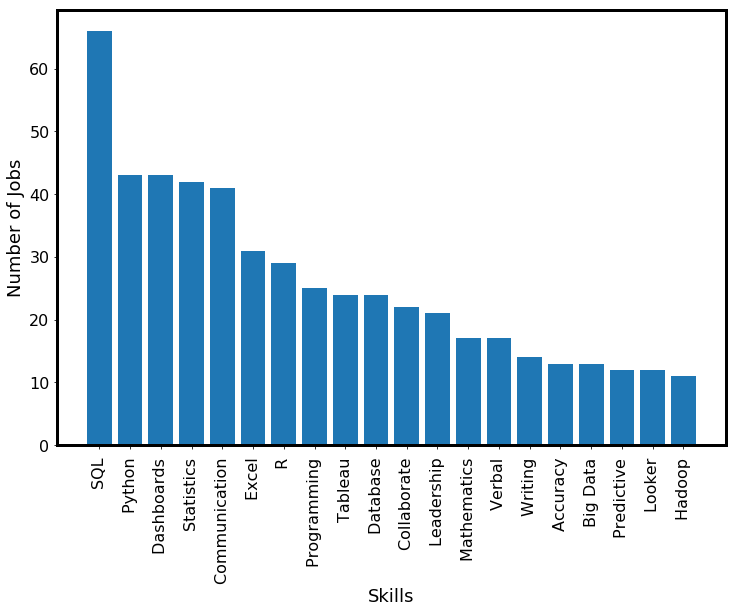

In [32]:
from pylab import *
fsize=16
fig = plt.figure()
plt.bar(TopSkills.index,TopSkills.values)
plt.xlabel('Skills',size=18)
plt.ylabel("Number of Jobs",size=18)
plt.xticks(rotation=90,fontsize=fsize)
plt.yticks(fontsize=fsize)
fig.set_figwidth(12)
fig.set_figheight(8)
[i.set_linewidth(3) for i in gca().spines.itervalues()]
plt.savefig('neha.png',bbox_inches='tight')
plt.show()



In [33]:
TechnicalSkills=finalff2[['SQL ','Dashboards ','Python ','Excel ','Tableau ','Database ','Mathematics ',' R ']]
SoftSkills=TopSkills[['Communication ','Writing ','Collaborate ','Leadership ','Verbal ','Writing ']]
finalff4=pd.DataFrame(finalff2)
finalff4['TechnicalSkills']=finalff4[['SQL ','Dashboards ','Python ','Excel ','Tableau ','Database ','Mathematics ',' R ']].sum(axis=1)
finalff4.TechnicalSkills[finalff4.TechnicalSkills >0]=1 
finalff4['SoftSkills']=finalff4[['Communication ','Writing ','Collaborate ','Leadership ','Verbal ','Writing ']].sum(axis=1)
finalff4.SoftSkills[finalff4.SoftSkills >0]=1
NumJobsRequireTechSkills=finalff4['TechnicalSkills'].sum()
NumJobsRequireSoftSkills=finalff4['SoftSkills'].sum()


c:\python27\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\python27\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Comaparison between Softskills vs Techskills required in Data Analyst Jobs

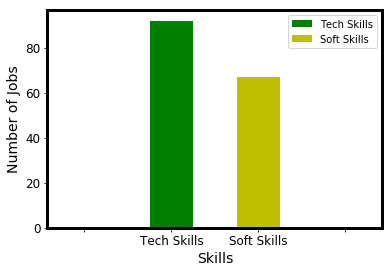

In [34]:

fsize=12
fig = plt.figure()
categories=["Tech Skills", "Soft Skills"]
values=[ NumJobsRequireTechSkills,NumJobsRequireSoftSkills]
plt.bar(" ",0,color='g',width=.5)
plt.bar("Tech Skills",NumJobsRequireTechSkills,color='g',width=.5,label='Tech Skills')
plt.bar("Soft Skills",NumJobsRequireSoftSkills,color='y',width=.5,label='Soft Skills')
plt.legend(loc='lower right')
plt.xlabel("Skills",size=14)
plt.ylabel("Number of Jobs",size=14)
plt.bar("  ",0,color='g',width=.5)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend()
[i.set_linewidth(3) for i in gca().spines.itervalues()]
plt.savefig('neha1.png',bbox_inches='tight')
plt.show()


# City wise Job categorization in Bay Area

In [35]:
cityWiseJOb=finalff4.groupby('city').size()
Top10City1=cityWiseJOb.sort_values(ascending=False)
Top10City=Top10City1.head(8)

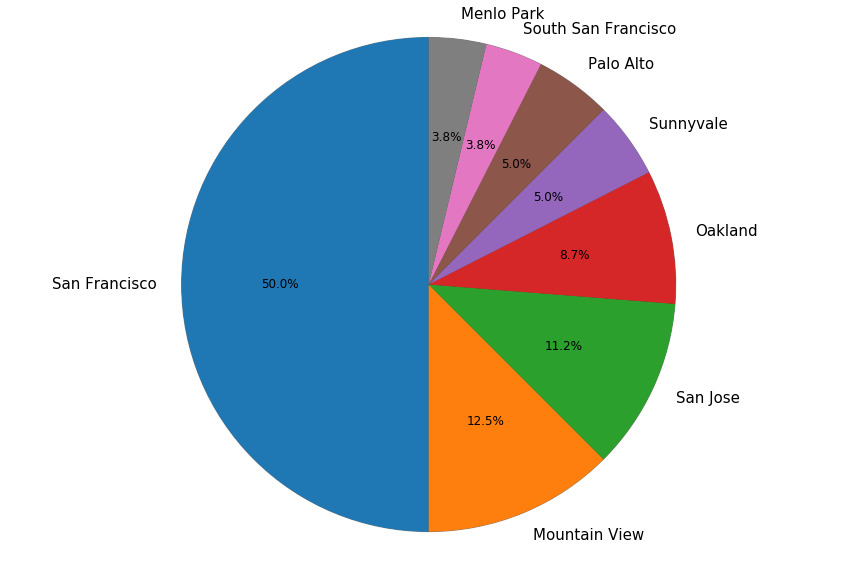

In [36]:
# The slices will be ordered and plotted counter-clockwise.
fig1, ax1 = plt.subplots()
labels = Top10City.index
sizes = Top10City.values
patches, texts, autotexts=ax1.pie(sizes,labels=labels,autopct='%1.1f%%',pctdistance = 0.6,shadow=True, startangle=90,radius=1.8 * 100, textprops={'fontsize': 12})
ax1.axis('equal')
fig1.set_figwidth(15)
fig1.set_figheight(10)

for t in texts:
    t.set_size(15)
plt.savefig('foo.png', dpi=400)
